# Modeling

### Import Modules

In [1]:
import pandas as pd
import numpy as np
import joblib
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from xgboost import XGBRegressor

### Model Selection

In [2]:
# Load the data (assuming preprocessing is already done, and you have train/test split)
train_data_pca = np.load('../data/train_data_step4_pca.npy')
train_data_salepricelog = pd.read_csv('../data/train_data_step4_salepricelog.csv')
y = train_data_salepricelog
X = train_data_pca

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
X_train.shape, X_test.shape

((1162, 20), (291, 20))

In [4]:
y_train.shape, y_test.shape

((1162, 1), (291, 1))

In [5]:
#convert y_train and y_test to 1D arrays
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

#initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42)
}

#cross-validation and RMSE
model_scores = {}
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)
    model_scores[name] = (rmse_scores.mean(), rmse_scores.std())
    print(f"{name}: CV RMSE = {rmse_scores.mean():.4f} +/- {rmse_scores.std():.4f}")

#display results
print("\nModel Performance (sorted by RMSE):")
sorted_models = sorted(model_scores.items(), key=lambda x: x[1][0])
for name, (mean_rmse, std_rmse) in sorted_models:
    print(f"{name}: CV RMSE = {mean_rmse:.4f} +/- {std_rmse:.4f}")

Linear Regression: CV RMSE = 0.1267 +/- 0.0058
Ridge Regression: CV RMSE = 0.1267 +/- 0.0058
Lasso Regression: CV RMSE = 0.1529 +/- 0.0071


C:\Users\aless\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\aless\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\aless\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\aless\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1351: DataConvers

Random Forest: CV RMSE = 0.1323 +/- 0.0062
XGBoost: CV RMSE = 0.1364 +/- 0.0076

Model Performance (sorted by RMSE):
Ridge Regression: CV RMSE = 0.1267 +/- 0.0058
Linear Regression: CV RMSE = 0.1267 +/- 0.0058
Random Forest: CV RMSE = 0.1323 +/- 0.0062
XGBoost: CV RMSE = 0.1364 +/- 0.0076
Lasso Regression: CV RMSE = 0.1529 +/- 0.0071


This process involves transforming the target variables, y_train and y_test, into one-dimensional arrays using .ravel() to ensure compatibility with the models. Multiple models were initialized, including Linear Regression, Ridge Regression, Lasso Regression, Random Forest Regressor, and XGBoost Regressor, each with different strengths in handling relationships and regularization. To evaluate performance, cross-validation is applied using Root Mean Squared Error (RMSE) as the primary metric, providing insights into how well the models generalize to unseen data. The results show that Ridge Regression performed best, achieving a lower RMSE with minimal variance, making it an ideal candidate for further tuning and deployment. The warning messages regarding the shape of y suggest minor adjustments in preprocessing, but they do not affect the validity of the comparisons.

### Hyperparameter Tuning

In [6]:
#define parameter grid for Ridge
ridge_param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0, 200.0, 500.0]}

#initialize Ridge model
ridge = Ridge()

#set up GridSearchCV
ridge_grid_search = GridSearchCV(ridge, ridge_param_grid, cv=5, scoring='neg_mean_squared_error')
ridge_grid_search.fit(X_train, y_train)

# Get the best parameters and the best RMSE score
best_ridge_model = ridge_grid_search.best_estimator_
best_ridge_params = ridge_grid_search.best_params_
best_ridge_rmse = np.sqrt(-ridge_grid_search.best_score_)

print(f"Best Ridge Regression Parameters: {best_ridge_params}")
print(f"Best Ridge Regression CV RMSE: {best_ridge_rmse:.4f}")

Best Ridge Regression Parameters: {'alpha': 100.0}
Best Ridge Regression CV RMSE: 0.1226


For the Ridge Regression model, a GridSearchCV is used to search over a grid of alpha values, which control the amount of regularization applied to the model. A range of alpha values from 0.1 to 500 is evaluated, and the best combination with the lowest Root Mean Squared Error (RMSE) is selected. The best result is achieved with an alpha value of 100, yielding an RMSE of 0.1226.

In [7]:
# Define the parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Initialize Random Forest model
rf = RandomForestRegressor(random_state=42)

# Set up GridSearchCV
rf_grid_search = GridSearchCV(rf, rf_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid_search.fit(X_train, y_train)

# Get the best parameters and the best RMSE score
best_rf_model = rf_grid_search.best_estimator_
best_rf_params = rf_grid_search.best_params_
best_rf_rmse = np.sqrt(-rf_grid_search.best_score_)

print(f"Best Random Forest Parameters: {best_rf_params}")
print(f"Best Random Forest CV RMSE: {best_rf_rmse:.4f}")

Best Random Forest Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Best Random Forest CV RMSE: 0.1343


Hyperparameter tuning is also applied to the Random Forest Regressor, where a grid search is performed over three hyperparameters: the number of trees (n_estimators), maximum depth (max_depth), and minimum samples per split (min_samples_split). The combination that minimizes the RMSE is selected, resulting in an RMSE of 0.1343, with 200 estimators, a maximum depth of 10, and a minimum of 5 samples per split. These carefully tuned parameters allow the models to generalize well to unseen data and reduce prediction errors.

### Model Training

In [8]:
#train final Ridge model
best_ridge_model.fit(X_train, y_train)

# Predict on the test set
y_pred_ridge_log = best_ridge_model.predict(X_test)

# Convert predictions back to the original scale
y_pred_ridge = np.expm1(y_pred_ridge_log)
y_test_original = np.expm1(y_test)

# Evaluate the model's performance
from sklearn.metrics import mean_squared_error

ridge_test_rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_ridge))
print(f"Ridge Regression Test RMSE: {ridge_test_rmse:.4f}")

Ridge Regression Test RMSE: 20452.6866


The Ridge model, identified in the preprocessing notebook as the best-performing linear regression variant during hyperparameter tuning, is trained on the X_train and y_train datasets. Predictions are generated using the test dataset, and the predicted values are transformed back from the log scale to their original form. The model’s performance is assessed using the Root Mean Squared Error (RMSE) metric, with a final Ridge Regression test RMSE of approximately 20452.6866.

In [9]:
#train final RF model
best_rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf_log = best_rf_model.predict(X_test)

# Convert predictions back to the original scale
y_pred_rf = np.expm1(y_pred_rf_log)

# Evaluate the model's performance
rf_test_rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_rf))
print(f"Random Forest Test RMSE: {rf_test_rmse:.4f}")

Random Forest Test RMSE: 22600.4205


The Random Forest model goes through the same process: training with the training dataset, followed by predictions using the test data. As with the Ridge model, the Random Forest predictions are reverted from the log scale to their original values. This model demonstrates an RMSE of 22600.4205. Both RMSE values indicate the average prediction error, with lower values suggesting better performance. In this case, the Ridge model outperforms the Random Forest model in terms of prediction accuracy on the test data.

### Model Evaluation

In [10]:
#compute RMSE and r-squared for Ridge
ridge_test_rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_ridge))
ridge_test_r2 = r2_score(y_test_original, y_pred_ridge)

print(f"Ridge Regression Test RMSE: {ridge_test_rmse:.4f}")
print(f"Ridge Regression Test R^2: {ridge_test_r2:.4f}")

#compute RMSE and r-squared for RF
rf_test_rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_rf))
rf_test_r2 = r2_score(y_test_original, y_pred_rf)

print(f"Random Forest Test RMSE: {rf_test_rmse:.4f}")
print(f"Random Forest Test R^2: {rf_test_r2:.4f}")

Ridge Regression Test RMSE: 20452.6866
Ridge Regression Test R^2: 0.9210
Random Forest Test RMSE: 22600.4205
Random Forest Test R^2: 0.9035


C:\Users\aless\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


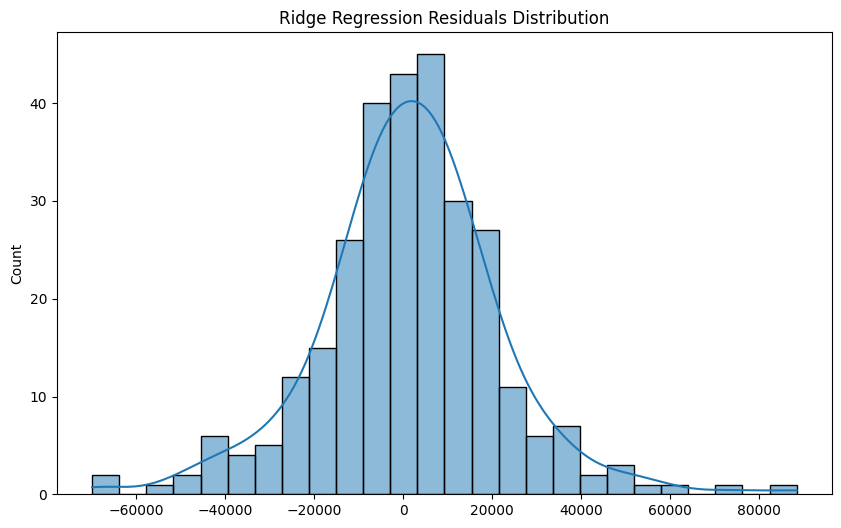

In [11]:
#residuals for Ridge
ridge_residuals = y_test_original - y_pred_ridge

plt.figure(figsize=(10, 6))
sns.histplot(ridge_residuals, kde=True)
plt.title('Ridge Regression Residuals Distribution')
plt.show()

Having residuals centered around zero indicates that the model performs reasonably well, with most predictions close to the true values. However, the presence of a few residuals at the extremes indicates some larger errors, meaning the model may struggle with certain data points.

C:\Users\aless\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


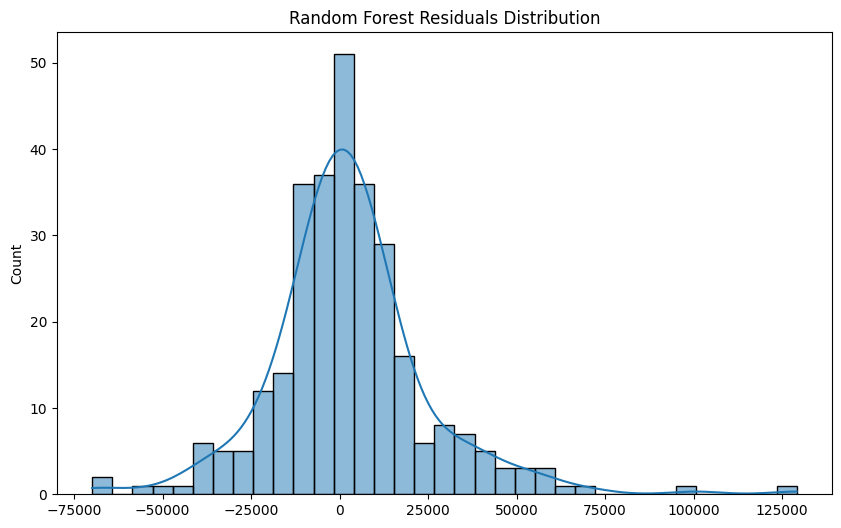

In [12]:
#residuals for RF
rf_residuals = y_test_original - y_pred_rf

plt.figure(figsize=(10, 6))
sns.histplot(rf_residuals, kde=True)
plt.title('Random Forest Residuals Distribution')
plt.show()

This histogram visualizes the RF residuals, showing whether they are normally distributed, which is desirable for model accuracy. In this plot, the spread of residuals reveals some errors, with a range extending beyond ±100,000, indicating that the model struggles with certain predictions. A high concentration near zero suggests most predictions are accurate, but the longer tails imply that the model might not handle extreme or outlier cases well.

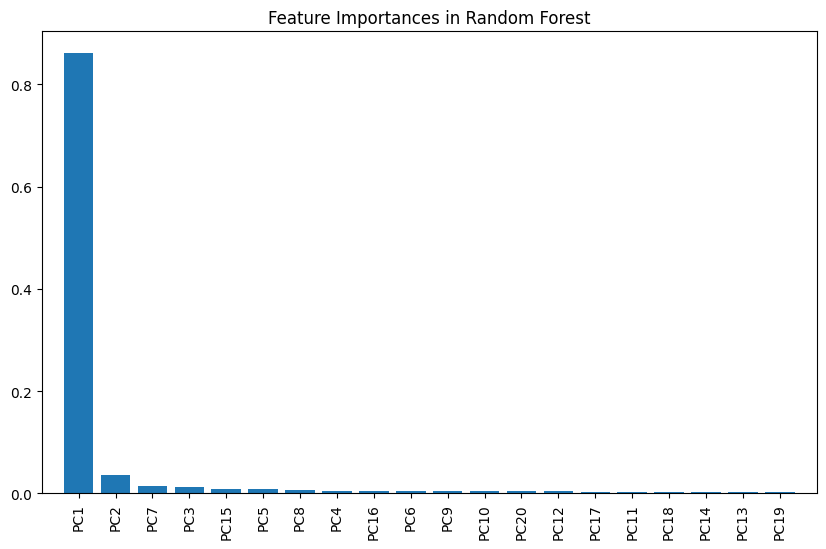

In [13]:
#feature importance for RF
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances in Random Forest")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), [f'PC{i+1}' for i in indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

This cell focuses on the visualization of feature importance derived from the Random Forest model. After the model was trained, the feature_importances_ attribute of the Random Forest provides a ranking of the features used during training based on their contribution to the predictive accuracy. However, because the dataset underwent PCA transformation, the features shown on the x-axis represent the Principal Components (PC1 to PC20) rather than original features.

The bar chart demonstrates that PC1 has the most significant influence on the model’s predictions, with a feature importance value close to 0.9, far surpassing other components. This suggests that the majority of the variance in the data is captured by the first principal component. The remaining components (PC2 to PC20) exhibit relatively low importance, indicating their minimal contribution to model performance.

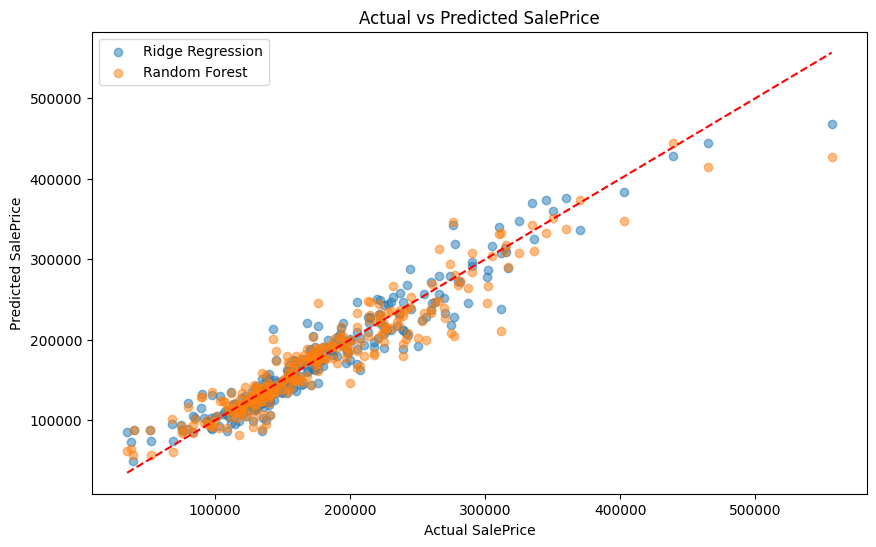

In [14]:
#pred vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_pred_ridge, alpha=0.5, label='Ridge Regression')
plt.scatter(y_test_original, y_pred_rf, alpha=0.5, label='Random Forest')
plt.plot([min(y_test_original), max(y_test_original)], [min(y_test_original), max(y_test_original)], 'r--')
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.title('Actual vs Predicted SalePrice')
plt.legend()
plt.show()

This is the visualization of the performance of two models—Ridge Regression and Random Forest—by plotting actual sale prices against the predicted sale prices. The orange and blue scatter points represent individual predictions made by the Random Forest and Ridge Regression models, respectively. The red dashed line serves as a reference line for perfect predictions, where actual and predicted values would align.

From the plot, it is observed that most of the points cluster along the red line, indicating the models have reasonable predictive accuracy. However, there are visible deviations, especially at higher sale prices, suggesting that both models struggle with more expensive properties. This comparison highlights the relative strengths and weaknesses of each model and helps visually validate their effectiveness in forecasting property prices.

### Ensembling

In [15]:
# Generate predictions on the test set
y_pred_ridge_log = best_ridge_model.predict(X_test)
y_pred_rf_log = best_rf_model.predict(X_test)

# Convert predictions back to the original scale
y_pred_ridge = np.expm1(y_pred_ridge_log)
y_pred_rf = np.expm1(y_pred_rf_log)

#blending the predictions (weighted average)
#define blended model class
class BlendedModel:
    def __init__(self, model1, model2, weight1=0.57, weight2=0.43):
        self.model1 = model1
        self.model2 = model2
        self.weight1 = weight1
        self.weight2 = weight2

    def predict(self, X):
        pred1 = self.model1.predict(X)
        pred2 = self.model2.predict(X)
        blended_prediction = (self.weight1 * pred1) + (self.weight2 * pred2)
        return blended_prediction

#instantiate blended model
best_blended_model = BlendedModel(model1=best_ridge_model, model2=best_rf_model, weight1=0.57, weight2=0.43)

#make predictions
y_pred_blended_log = best_blended_model.predict(X_test)
y_pred_blended = np.expm1(y_pred_blended_log)

# Evaluate the blended model's performance
blended_rmse = np.sqrt(mean_squared_error(np.expm1(y_test), y_pred_blended))
blended_r2 = r2_score(np.expm1(y_test), y_pred_blended)
print(f"Blended Model Test RMSE: {blended_rmse:.4f}")
print(f"Blended Model Test R²: {blended_r2:.4f}")

Blended Model Test RMSE: 20446.5387
Blended Model Test R²: 0.9210


The Blended Model Test RMSE is lower than the RMSE values for the inidivual models, this confirms that blending these two effectively leverages the strengths of the individual models. The same is also true for the blended r-squared value as it proves that the blended model explains more of the data's variance than its individual substituents.

C:\Users\aless\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


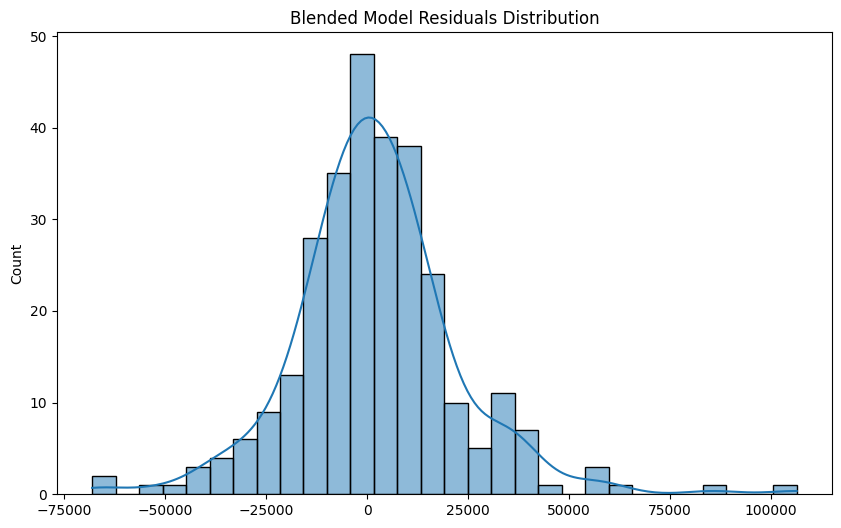

In [16]:
#residuals for blended model
blended_residuals = np.expm1(y_test) - y_pred_blended

#plot residuals distribution
plt.figure(figsize=(10, 6))
sns.histplot(blended_residuals, kde=True)
plt.title('Blended Model Residuals Distribution')
plt.show()

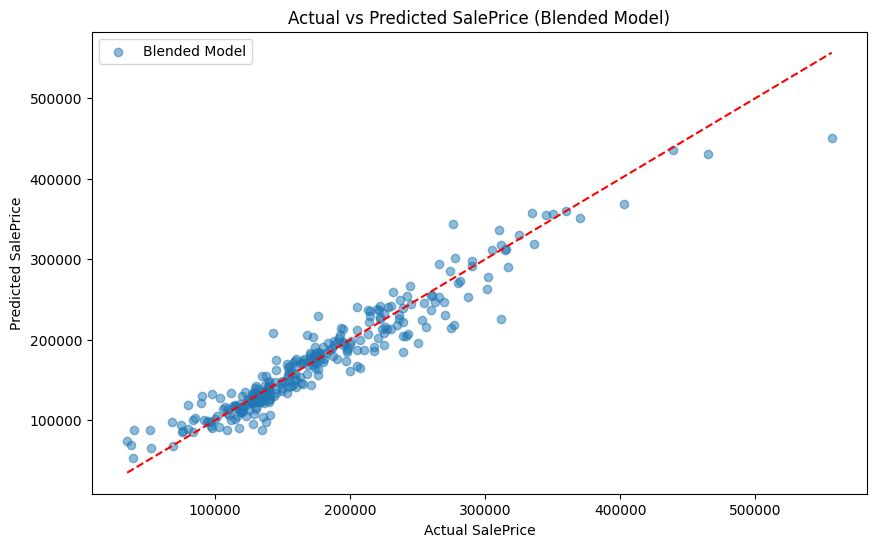

In [17]:
#blended model pred vs. actual
plt.figure(figsize=(10, 6))
plt.scatter(np.expm1(y_test), y_pred_blended, alpha=0.5, label='Blended Model')
plt.plot([min(np.expm1(y_test)), max(np.expm1(y_test))], [min(np.expm1(y_test)), max(np.expm1(y_test))], 'r--')
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.title('Actual vs Predicted SalePrice (Blended Model)')
plt.legend()
plt.show()

### Save Model

In [18]:
#save blended model
joblib.dump(best_blended_model, '../models/final_blended_model.pkl')

['../models/final_blended_model.pkl']

In this project, I developed a predictive model to estimate house prices using several machine learning techniques, including Ridge Regression, Random Forest, and a blended model. I began with thorough preprocessing, handling missing data, encoding categorical features, scaling numerical features, applying variance thresholding, and using Principal Component Analysis (PCA) to reduce dimensionality. Each of these steps ensured the dataset was properly prepared for model training and prevented redundancy and noise from influencing the models.

Ridge Regression was chosen because of its ability to reduce overfitting by applying regularization, which penalizes large coefficients, helping the model generalize better. Random Forest, with its ensemble-based structure, was included to capture non-linear patterns, though it has a higher risk of overfitting due to its ability to learn detailed relationships from the data. To balance these strengths and trade-offs, I created a blended model, combining Ridge Regression and Random Forest, aiming to leverage both regularization and the non-linear predictive power.

The blended model delivered a high R-squared value of 0.9210, indicating it explained 92.1% of the variance in sale prices. While this performance suggests the model is effective, overfitting is a potential concern given the high R-squared score. To mitigate this, I incorporated cross-validation throughout the model development process to evaluate performance across multiple data splits, ensuring the model didn’t simply memorize patterns from the training set.

Additionally, I assessed model performance using root mean squared error (RMSE) to measure the average prediction error, confirming that the predictions closely align with actual sale prices. I also analyzed the residuals (the difference between actual and predicted values) for each model to confirm normal error distribution and detect potential outliers. The Actual vs. Predicted SalePrice plot for the blended model revealed that predictions tracked closely with real values, though some discrepancies at higher price points suggested areas for improvement.

Through this project, I learned how to carefully balance model complexity with the need for generalizability. The blended model, combining the benefits of Ridge Regression and Random Forest, demonstrated that it is possible to reduce the risk of overfitting while capturing meaningful relationships in the data.